# Generate the missing data

The dataset is still missing 19 sentences reflecting Double Negation and 113 for the Diminutives and Augmentatives. 

In [1]:
# %pip install bert_score

In [2]:
import string
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from bert_score import score

np.random.seed(2)

def has_double_negation(sentence):
    """Check if the sentence contains double negation."""
    negative_words = ["niente", "nessuno", "nessuna", "nessun", "nulla"]
    words = sentence.lower().split()
    return words.count("non") > 1 or "non" in words and any(word in words for word in negative_words)

with open("./Datasets/Diminutives-Augmentatives.txt", 'r', encoding='utf-8') as file:
    diminutives_augmentatives = [line.strip() for line in file]

def has_diminutives_or_augmentatives(sentence):
    """Check if the sentence contains diminutives or augmentatives."""
    suffixes = ["ino", "ina", "etto", "etta", "accio", "accia", "one", "ona"]
    sentence_no_punct = sentence.translate(str.maketrans("", "", string.punctuation))
    return any(word for word in sentence_no_punct.split() if word in diminutives_augmentatives)

# Load the NLLB model and tokenizer from Hugging Face
model_name = "facebook/nllb-200-distilled-600M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

source_lang_code = "ita_Latn"  # Italian
target_lang_code = "nld_Latn"  # Dutch

def nllb_model(italian_sentence, dutch_sentence):
    input_sentence = f">>{source_lang_code}<< {italian_sentence}"

    inputs = tokenizer(input_sentence, return_tensors="pt", max_length=512, truncation=True)

    # Generate translation
    with torch.no_grad():
        translated_tokens = model.generate(**inputs, forced_bos_token_id=tokenizer.convert_tokens_to_ids(f">>{target_lang_code}<<"))
    translated_sentence = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)

    if translated_sentence == dutch_sentence:
        return 1.0  # Perfect match
    else:
        return calculate_similarity(translated_sentence, dutch_sentence)

# Calculate similarity using BERTScore
def calculate_similarity(translated, reference):
    P, R, F1 = score([translated], [reference], lang="nl")
    return F1.item()

def evaluate_llm_output(llm_response_path, verify_phenomenon, prompt_type="zero-shot"):
    """
    Evaluates the LLM output based on linguistic validity, diversity, and translation quality.
    
    Parameters:
        llm_response_path (str): Path to the text file containing the output from the LLM, expected to be a JSON list or a list of JSON objects.
        verify_phenomenon (function): A function that takes a sentence and checks if it reflects the target phenomenon.
        prompt_type (str): The type of prompt used for the LLM response (default: "zero-shot").
        
    Returns:
        dict: A dictionary with evaluation metrics:
            - valid_sentences: List of valid sentences with translations.
            - linguistic_validity: Percentage of sentences valid for the phenomenon.
            - diversity: Metric for diversity (e.g., number of unique words/total words ratio).
            - total_sentences: Total number of sentences processed.
            - avg_translation_quality: Average quality score of translations.
    """
    try:
        with open(llm_response_path, "r", encoding="utf-8") as file:
            llm_response = file.read()
        
        # Extract JSON-like content from the response
        json_pattern = re.search(r"\[.*\]", llm_response, re.DOTALL)
        if json_pattern:
            data = json.loads(json_pattern.group(0))  # Parse JSON content
        else:
            return {"valid_sentences": [], "linguistic_validity": 0, "diversity": 0, "total_sentences": 0, "avg_translation_quality": 0}
        
        # Ensure it's a list of JSON objects
        if not isinstance(data, list):
            raise ValueError("The LLM response is not a JSON list.")
        
        # Extract sentences and translations
        sentences_with_translations = []
        for item in data:
            if "Italian" in item and "Dutch" in item:
                sentences_with_translations.append((item["Italian"], item["Dutch"]))
        
        # Initialize metrics
        valid_sentences = []
        all_words = []
        total_quality_score = 0
        quality_scores_count = 0

        # Evaluate sentences
        for italian, dutch in sentences_with_translations:
            if verify_phenomenon(italian):
                valid_sentences.append({"Italian": italian, "Dutch": dutch})
                all_words.extend(italian.split())  # Collect words for diversity

                # Use NLLB model to evaluate translation quality
                quality_score = nllb_model(italian, dutch)
                total_quality_score += quality_score
                quality_scores_count += 1
        
        # Calculate metrics
        total_sentences = len(sentences_with_translations)
        linguistic_validity = len(valid_sentences) / total_sentences if total_sentences > 0 else 0
        unique_words = len(set(all_words))
        diversity = unique_words / len(all_words) if all_words else 0
        avg_translation_quality = total_quality_score / quality_scores_count if quality_scores_count > 0 else 0

        # Return metrics
        return {
            "prompt_type": prompt_type,
            "total_sentences": total_sentences,
            "valid_sentences": len(valid_sentences),
            "linguistic_validity": round(linguistic_validity * 100, 2),
            "diversity": round(diversity * 100, 2),
            "avg_translation_quality": round(avg_translation_quality * 100, 2),
        }, valid_sentences

    except (json.JSONDecodeError, ValueError) as e:
        raise ValueError(f"An error occurred while processing the LLM response: {e}")
    
def plot_metrics(metrics_data):
    metrics = ['total_sentences', 'valid_sentences', 'linguistic_validity', 'avg_translation_quality', 'diversity']
    num_objects = len(metrics_data)

    values = [[obj[metric] for metric in metrics] for obj in metrics_data]
    labels = [obj['prompt_type'] for obj in metrics_data]

    values = np.array(values)

    x = np.arange(num_objects)
    width = 0.15
    colors = sns.color_palette("rainbow", 15)

    fig, ax = plt.subplots(figsize=(10, 6))

    for i in range(5):
        ax.bar(x + i * width, values[:, i], width, label=metrics[i].replace('_', ' ').title(), color=colors[i * 3])

    ax.set_xlabel('Prompt Type')
    ax.set_ylabel('Value')
    ax.set_title('Metrics for Each Prompt Type')
    ax.set_xticks(x + width * 2.5)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.tight_layout()
    plt.show()

# Subject Omission

## Zero-shot Prompt

"Generate 20 Italian sentence and Their Dutch translation that reflect the linguistic phenomena of Double Negation. Give your output in a list of json objects with the fields 'Italian' and 'Dutch'."

In [3]:
dn_zero_shot_metrics, dn_zero_shot_sentences = evaluate_llm_output('LLM-Responses/Double-Negation/DN-Zero-Shot.txt', verify_phenomenon=has_double_negation, prompt_type="zero-shot")
dn_zero_shot_metrics

{'prompt_type': 'zero-shot',
 'total_sentences': 21,
 'valid_sentences': 20,
 'linguistic_validity': 95.24,
 'diversity': 42.58,
 'avg_translation_quality': 63.19}

## One-shot Prompt

Generate 20 Italian sentences and Their Dutch translation that reflect the linguistic phenomena of Double Negation like 'Non ho mangiato nulla' : 'Ik heb niets gegeten'. Give your output in a list of json objects with the fields 'Italian' and 'Dutch'.

In [4]:
dn_one_shot_metrics, dn_one_shot_sentences = evaluate_llm_output('LLM-Responses/Double-Negation/DN-One-Shot.txt', verify_phenomenon=has_double_negation, prompt_type="one-shot")
dn_one_shot_metrics

{'prompt_type': 'one-shot',
 'total_sentences': 20,
 'valid_sentences': 13,
 'linguistic_validity': 65.0,
 'diversity': 54.55,
 'avg_translation_quality': 61.79}

## Zero-shot prompt with explanation

Generate 20 Italian sentences and Their Dutch translation that reflect the linguistic phenomena of Double Negation. Double Negation occurs when a sentence has both the negative particle 'non' and another negative word between 'niente', 'nessuno', 'nessuna', 'nessun', 'nulla'. Give your output in a list of json objects with the fields 'Italian' and 'Dutch'.

In [5]:
dn_zero_shot_exp_metrics, dn_zero_shot_exp_sentences = evaluate_llm_output(
    'LLM-Responses/Double-Negation/DN-Zero-Shot-Exp.txt', verify_phenomenon=has_double_negation, prompt_type="zero-shot-explanation")
dn_zero_shot_exp_metrics

{'prompt_type': 'zero-shot-explanation',
 'total_sentences': 20,
 'valid_sentences': 15,
 'linguistic_validity': 75.0,
 'diversity': 59.17,
 'avg_translation_quality': 73.8}

## One-shot prompt with explanation

Generate 20 Italian sentences and Their Dutch translation that reflect the linguistic phenomena of Double Negation. Double Negation occurs when a sentence has both the negative particle 'non' and another negative word between 'niente', 'nessuno', 'nessuna', 'nessun', 'nulla' like 'Non ho mangiato nulla' : 'Ik heb niets gegeten'. Give your output in a list of json objects with the fields 'Italian' and 'Dutch'.

In [6]:
dn_one_shot_exp_metrics, dn_one_shot_exp_sentences = evaluate_llm_output(
    'LLM-Responses/Double-Negation/DN-One-Shot-Exp.txt', verify_phenomenon=has_double_negation, prompt_type="one-shot-explanation")
dn_one_shot_exp_metrics

{'prompt_type': 'one-shot-explanation',
 'total_sentences': 20,
 'valid_sentences': 11,
 'linguistic_validity': 55.0,
 'diversity': 53.57,
 'avg_translation_quality': 62.27}

# Plot the metrics

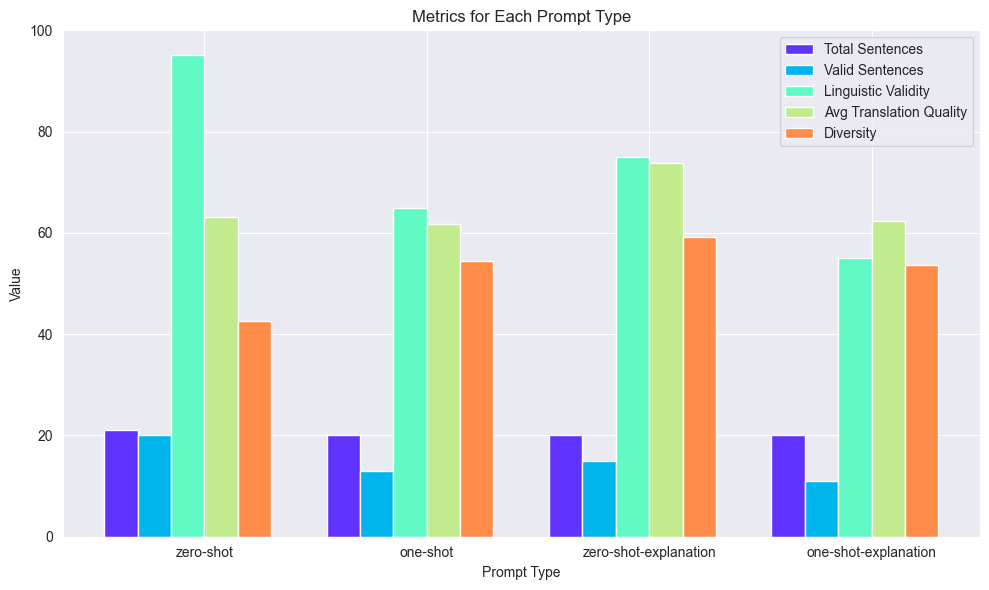

In [7]:
plot_metrics([dn_zero_shot_metrics, dn_one_shot_metrics, dn_zero_shot_exp_metrics, dn_one_shot_exp_metrics])

Zero shot prompt with explanation has the highest average translation quality and diversity. We will use this prompt to generate more sentences.

In [8]:
len(dn_zero_shot_exp_sentences)

15

In [9]:
additional_dn_zero_shot_exp_metrics, additional_dn_zero_shot_exp_sentences = evaluate_llm_output(
    'LLM-Responses/Double-Negation/DN-Zero-Shot-Exp-Additional.txt', verify_phenomenon=has_double_negation, prompt_type="zero-shot-explanation")
additional_dn_zero_shot_exp_metrics

{'prompt_type': 'zero-shot-explanation',
 'total_sentences': 4,
 'valid_sentences': 4,
 'linguistic_validity': 100.0,
 'diversity': 79.17,
 'avg_translation_quality': 79.49}

In [10]:
generated_dn_sentences = dn_zero_shot_exp_sentences + additional_dn_zero_shot_exp_sentences

with open("./Datasets/Double-Negation-Generated-IT-NL.tsv", "w", encoding="utf-8") as f:
    f.write("Italian\tDutch\n")
    for item in generated_dn_sentences:
        f.write(f"{item['Italian']}\t{item['Dutch']}\n")

# Diminutives and Augmentatives

## Zero-shot Prompt

Generate 20 Italian sentences and their Dutch translation that reflect the linguistic use of diminutives and augmentatives. Give your output in a list of json objects with the fields 'Italian' and 'Dutch'.

In [11]:
da_zero_shot_metrics, da_zero_shot_sentences = evaluate_llm_output(
    'LLM-Responses/Diminutives-Augmentatives/DA-Zero-Shot.txt', verify_phenomenon=has_diminutives_or_augmentatives, prompt_type="zero-shot")
da_zero_shot_metrics

{'prompt_type': 'zero-shot',
 'total_sentences': 20,
 'valid_sentences': 4,
 'linguistic_validity': 20.0,
 'diversity': 92.59,
 'avg_translation_quality': 80.27}

## One-shot Prompt

Generate 20 Italian sentences and their Dutch translation that reflect the linguistic use of diminutives and augmentatives, like 'Ho un gattino' : 'Ik heb een katje'. Give your output in a list of json objects with the fields 'Italian' and 'Dutch'.

In [12]:
da_one_shot_metrics, da_one_shot_sentences = evaluate_llm_output(
    'LLM-Responses/Diminutives-Augmentatives/DA-One-Shot.txt', verify_phenomenon=has_diminutives_or_augmentatives, prompt_type="one-shot")
da_one_shot_metrics

{'prompt_type': 'one-shot',
 'total_sentences': 20,
 'valid_sentences': 14,
 'linguistic_validity': 70.0,
 'diversity': 63.74,
 'avg_translation_quality': 60.91}

## Zero-shot prompt with explanation

Generate 20 Italian sentences and their Dutch translation that reflect the linguistic use of diminutives and augmentatives. Diminutives and augmentatives in Italian are formed with the use of the suffixes 'ino', 'ina', 'etto', 'etta', 'one', 'ona', 'accio', 'accia'. Give your output in a list of json objects with the fields 'Italian' and 'Dutch'.

In [13]:
da_zero_shot_exp_metrics, da_zero_shot_exp_sentences = evaluate_llm_output(
    'LLM-Responses/Diminutives-Augmentatives/DA-Zero-Shot-Exp.txt', verify_phenomenon=has_diminutives_or_augmentatives, prompt_type="zero-shot-explanation")
da_zero_shot_exp_metrics

{'prompt_type': 'zero-shot-explanation',
 'total_sentences': 20,
 'valid_sentences': 10,
 'linguistic_validity': 50.0,
 'diversity': 78.33,
 'avg_translation_quality': 60.31}

## One-shot prompt with explanation

Generate 20 Italian sentences and their Dutch translation that reflect the linguistic use of diminutives and augmentatives. Diminutives and augmentatives in Italian are formed with the use of the suffixes 'ino', 'ina', 'etto', 'etta', 'one', 'ona', 'accio', 'accia', like 'Ho un gattino' : 'Ik heb een katje'. Give your output in a list of json objects with the fields 'Italian' and 'Dutch'.

In [14]:
da_one_shot_exp_metrics, da_one_shot_exp_sentences = evaluate_llm_output(
    'LLM-Responses/Diminutives-Augmentatives/DA-One-Shot-exp.txt', verify_phenomenon=has_diminutives_or_augmentatives, prompt_type="one-shot-explanation")
da_one_shot_exp_metrics

{'prompt_type': 'one-shot-explanation',
 'total_sentences': 20,
 'valid_sentences': 9,
 'linguistic_validity': 45.0,
 'diversity': 75.51,
 'avg_translation_quality': 70.17}

# Plot the metrics

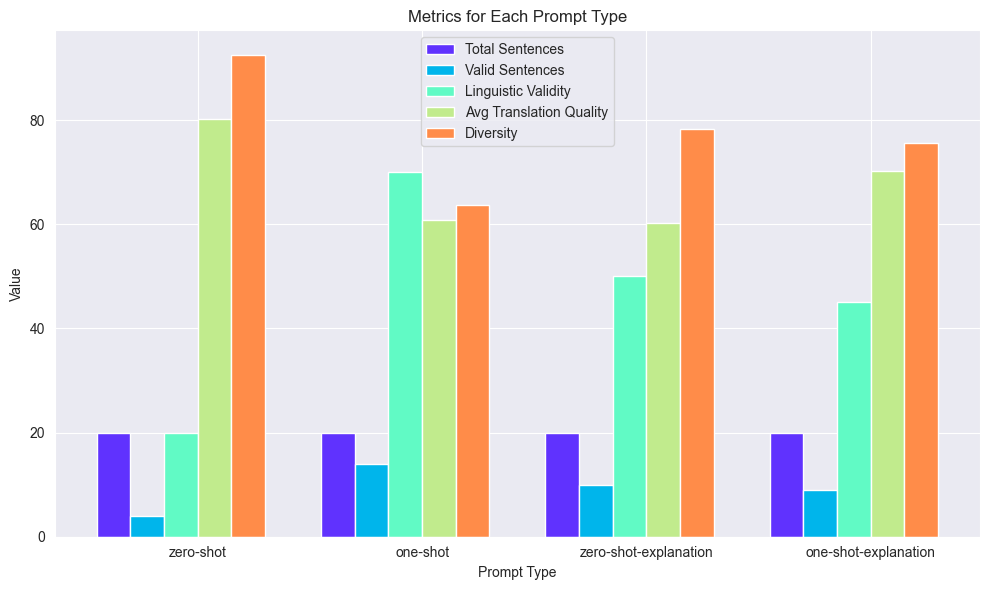

In [15]:
plot_metrics([da_zero_shot_metrics, da_one_shot_metrics, da_zero_shot_exp_metrics, da_one_shot_exp_metrics])

The zero-shot prompt achieved the highest average translation quality and diversity, which might be due to its very low linguistic validity, with only 4 valid sentences. Therefore, we will use the one-shot prompt with explanation, which has an average translation quality just 1.2% lower and still maintains 75% diversity.

In [16]:
len(da_one_shot_exp_sentences)

9

In [17]:
additional_da_one_shot_exp_metrics, additional_da_one_shot_exp_sentences = evaluate_llm_output(
    'LLM-Responses/Diminutives-Augmentatives/DA-One-Shot-Exp-Additional.txt', verify_phenomenon=has_diminutives_or_augmentatives, prompt_type="one-shot-explanation")
additional_da_one_shot_exp_metrics

{'prompt_type': 'one-shot-explanation',
 'total_sentences': 20,
 'valid_sentences': 12,
 'linguistic_validity': 60.0,
 'diversity': 62.5,
 'avg_translation_quality': 67.55}

In [18]:
additional_da_one_shot_exp_metrics1, additional_da_one_shot_exp_sentences1 = evaluate_llm_output(
    'LLM-Responses/Diminutives-Augmentatives/DA-One-Shot-Exp-Additional1.txt', verify_phenomenon=has_diminutives_or_augmentatives, prompt_type="one-shot-explanation")
additional_da_one_shot_exp_metrics1

{'prompt_type': 'one-shot-explanation',
 'total_sentences': 20,
 'valid_sentences': 12,
 'linguistic_validity': 60.0,
 'diversity': 60.78,
 'avg_translation_quality': 69.45}

In [19]:
additional_da_one_shot_exp_metrics2, additional_da_one_shot_exp_sentences2 = evaluate_llm_output(
    'LLM-Responses/Diminutives-Augmentatives/DA-One-Shot-Exp-Additional2.txt', verify_phenomenon=has_diminutives_or_augmentatives, prompt_type="one-shot-explanation")
additional_da_one_shot_exp_metrics2

{'prompt_type': 'one-shot-explanation',
 'total_sentences': 19,
 'valid_sentences': 6,
 'linguistic_validity': 31.58,
 'diversity': 76.92,
 'avg_translation_quality': 60.07}

In [20]:
additional_da_one_shot_exp_metrics3, additional_da_one_shot_exp_sentences3 = evaluate_llm_output(
    'LLM-Responses/Diminutives-Augmentatives/DA-One-Shot-Exp-Additional3.txt', verify_phenomenon=has_diminutives_or_augmentatives, prompt_type="one-shot-explanation")
additional_da_one_shot_exp_metrics3

{'prompt_type': 'one-shot-explanation',
 'total_sentences': 20,
 'valid_sentences': 11,
 'linguistic_validity': 55.0,
 'diversity': 68.33,
 'avg_translation_quality': 71.61}

In [21]:
additional_da_one_shot_exp_metrics4, additional_da_one_shot_exp_sentences4 = evaluate_llm_output(
    'LLM-Responses/Diminutives-Augmentatives/DA-One-Shot-Exp-Additional4.txt', verify_phenomenon=has_diminutives_or_augmentatives, prompt_type="one-shot-explanation")
additional_da_one_shot_exp_metrics4

{'prompt_type': 'one-shot-explanation',
 'total_sentences': 20,
 'valid_sentences': 14,
 'linguistic_validity': 70.0,
 'diversity': 66.3,
 'avg_translation_quality': 66.15}

In [22]:
additional_da_one_shot_exp_metrics5, additional_da_one_shot_exp_sentences5 = evaluate_llm_output(
    'LLM-Responses/Diminutives-Augmentatives/DA-One-Shot-Exp-Additional5.txt', verify_phenomenon=has_diminutives_or_augmentatives, prompt_type="one-shot-explanation")
additional_da_one_shot_exp_metrics5

{'prompt_type': 'one-shot-explanation',
 'total_sentences': 20,
 'valid_sentences': 12,
 'linguistic_validity': 60.0,
 'diversity': 68.92,
 'avg_translation_quality': 70.45}

In [23]:
additional_da_one_shot_exp_metrics6, additional_da_one_shot_exp_sentences6 = evaluate_llm_output(
    'LLM-Responses/Diminutives-Augmentatives/DA-One-Shot-Exp-Additional6.txt', verify_phenomenon=has_diminutives_or_augmentatives, prompt_type="one-shot-explanation")
additional_da_one_shot_exp_metrics6

{'prompt_type': 'one-shot-explanation',
 'total_sentences': 19,
 'valid_sentences': 10,
 'linguistic_validity': 52.63,
 'diversity': 70.49,
 'avg_translation_quality': 70.01}

In [24]:
additional_da_one_shot_exp_metrics7, additional_da_one_shot_exp_sentences7 = evaluate_llm_output(
    'LLM-Responses/Diminutives-Augmentatives/DA-One-Shot-Exp-Additional7.txt', verify_phenomenon=has_diminutives_or_augmentatives, prompt_type="one-shot-explanation")
additional_da_one_shot_exp_metrics7

{'prompt_type': 'one-shot-explanation',
 'total_sentences': 19,
 'valid_sentences': 9,
 'linguistic_validity': 47.37,
 'diversity': 74.19,
 'avg_translation_quality': 58.67}

In [25]:
additional_da_one_shot_exp_metrics8, additional_da_one_shot_exp_sentences8 = evaluate_llm_output(
    'LLM-Responses/Diminutives-Augmentatives/DA-One-Shot-Exp-Additional8.txt', verify_phenomenon=has_diminutives_or_augmentatives, prompt_type="one-shot-explanation")
additional_da_one_shot_exp_metrics8

{'prompt_type': 'one-shot-explanation',
 'total_sentences': 19,
 'valid_sentences': 12,
 'linguistic_validity': 63.16,
 'diversity': 70.79,
 'avg_translation_quality': 63.42}

In [26]:
additional_da_one_shot_exp_metrics9, additional_da_one_shot_exp_sentences9 = evaluate_llm_output(
    'LLM-Responses/Diminutives-Augmentatives/DA-One-Shot-Exp-Additional9.txt', verify_phenomenon=has_diminutives_or_augmentatives, prompt_type="one-shot-explanation")
additional_da_one_shot_exp_metrics9

{'prompt_type': 'one-shot-explanation',
 'total_sentences': 19,
 'valid_sentences': 12,
 'linguistic_validity': 63.16,
 'diversity': 70.79,
 'avg_translation_quality': 63.42}

In [27]:
generated_da_sentences = additional_da_one_shot_exp_sentences + additional_da_one_shot_exp_sentences1 + additional_da_one_shot_exp_sentences2 + additional_da_one_shot_exp_sentences3 + additional_da_one_shot_exp_sentences4 + additional_da_one_shot_exp_sentences5 + additional_da_one_shot_exp_sentences6 + additional_da_one_shot_exp_sentences7 + additional_da_one_shot_exp_sentences8 + additional_da_one_shot_exp_sentences9

with open("./Datasets/Diminutives-Augmentatives-Generated-IT-NL.tsv", "w", encoding="utf-8") as f:
    f.write("Italian\tDutch\n")
    for item in generated_da_sentences:
        f.write(f"{item['Italian']}\t{item['Dutch']}\n")